In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr #来计算变量之间的相关系数和p-value

VAR是Vector Autoregression的缩写，它是一种广泛用于分析多个时间序列的统计模型。 
VAR（Vector Autoregression）模型的一般形式可以表示为：
$y_t=c+A_1 y_{t-1}+A_2 y_{t-2}+\ldots+A_p y_{t-p}+\varepsilon_t$
其中，$y_{t}$ 是一个 $k$ 维向量，表示 $k$ 个时间序列在时刻 $t$ 的值。$p$ 表示模型中使用多少个滞后期，$\varepsilon_{t}$ 表示 $k$ 维误差向量，$c$ 是一个 $k$ 维常量向量，$A_{1}, A_{2}, ..., A_{p}$ 是 $k \times k$ 的矩阵。

VAR 模型基于两个主要假设：首先，每个时间序列都可以被其自身的滞后期和其他时间序列的滞后期所解释。其次，所有时间序列之间存在互相影响的关系。该模型的主要目的是通过分析这些互相影响的关系，来对每个时间序列进行预测。

# Read the Data

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
def parser(s):
    return datetime.strptime(s, '%Y-%m')


In [7]:
ice_cream_heater_df = pd.read_csv('ice_cream_vs_heater.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [8]:
ice_cream_heater_df = ice_cream_heater_df.asfreq(pd.infer_freq(ice_cream_heater_df.index))

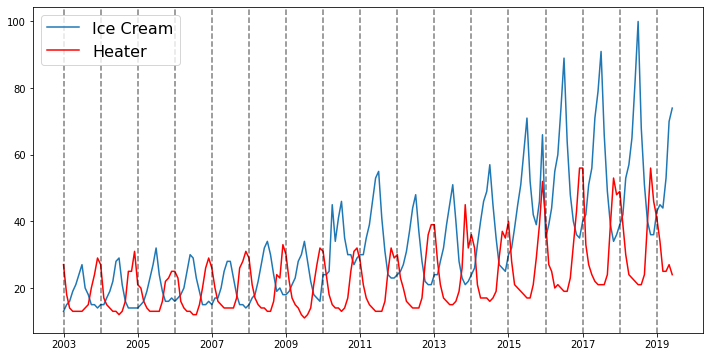

In [9]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'])
heater, = plt.plot(ice_cream_heater_df['heater'], color='red')

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

# Normalize

In [10]:
avgs = ice_cream_heater_df.mean()
devs = ice_cream_heater_df.std()

In [11]:
for col in ice_cream_heater_df.columns:
    ice_cream_heater_df[col] = (ice_cream_heater_df[col] - avgs.loc[col]) / devs.loc[col]

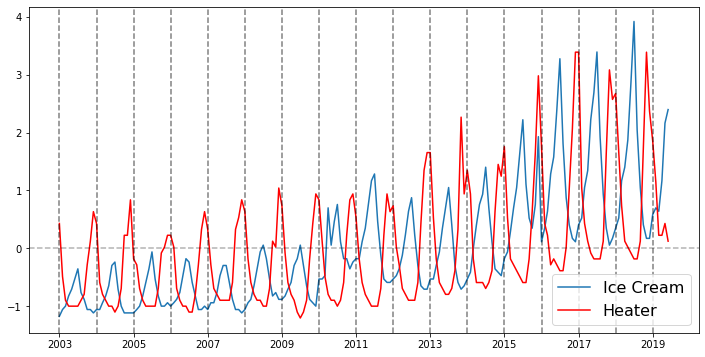

In [12]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'])
heater, = plt.plot(ice_cream_heater_df['heater'], color='red')

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

# Take First Difference to Remove Trend

In [13]:
ice_cream_heater_df = ice_cream_heater_df.diff().dropna()

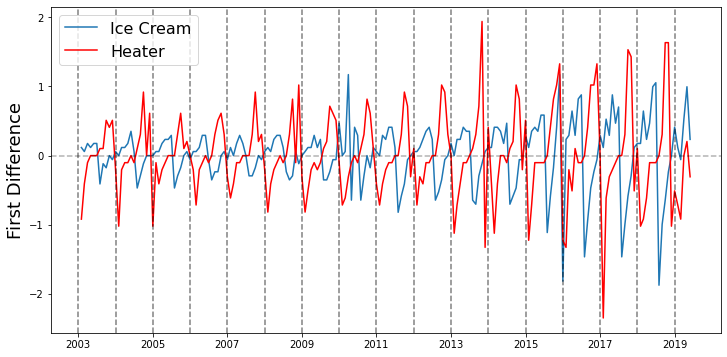

In [14]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'])
heater, = plt.plot(ice_cream_heater_df['heater'], color='red')

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

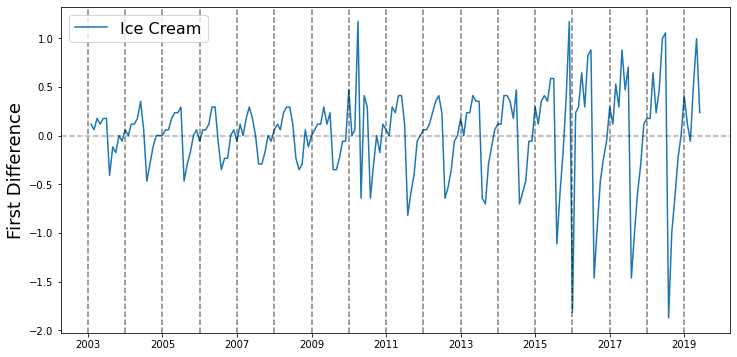

In [15]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'])

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream'], fontsize=16)

# Remove Increasing Volatility

In [16]:
annual_volatility = ice_cream_heater_df.groupby(ice_cream_heater_df.index.year).std()

In [17]:
annual_volatility

,heater,ice cream
Month,,
2004,0.415481,0.184201
2005,0.474527,0.214837
2006,0.400148,0.227698
2007,0.359839,0.198947
2008,0.396182,0.183239
2009,0.499810,0.221038
2010,0.459566,0.211668
2011,0.443924,0.501018
2012,0.471104,0.389711


In [18]:
ice_cream_heater_df['ice_cream_annual_vol'] = ice_cream_heater_df.index.map(lambda d: annual_volatility.loc[d.year, 'ice cream'])
ice_cream_heater_df['heater_annual_vol'] = ice_cream_heater_df.index.map(lambda d: annual_volatility.loc[d.year, 'heater'])

In [19]:
ice_cream_heater_df

,heater,ice cream,ice_cream_annual_vol,heater_annual_vol
Month,,,,
2004-02-01,-0.918789,0.117140,0.184201,0.415481
2004-03-01,-0.408351,0.058570,0.184201,0.415481
2004-04-01,-0.102088,0.175710,0.184201,0.415481
2004-05-01,0.000000,0.117140,0.184201,0.415481
2004-06-01,0.000000,0.175710,0.184201,0.415481
...,...,...,...,...
2020-02-01,-0.714614,0.117140,0.369810,0.426657
2020-03-01,-0.918789,-0.058570,0.369810,0.426657
2020-04-01,0.000000,0.527129,0.369810,0.426657


In [20]:
ice_cream_heater_df['ice cream'] = ice_cream_heater_df['ice cream'] / ice_cream_heater_df['ice_cream_annual_vol']
ice_cream_heater_df['heater'] = ice_cream_heater_df['heater'] / ice_cream_heater_df['heater_annual_vol']

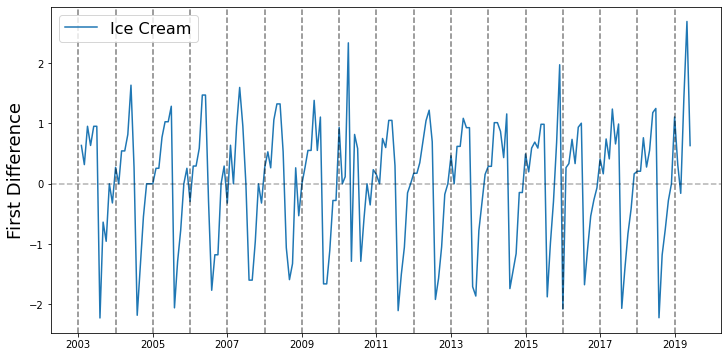

In [21]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'])

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream'], fontsize=16)

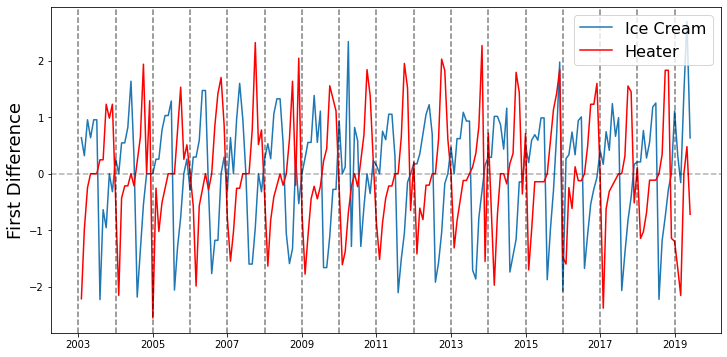

In [22]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'])
heater, = plt.plot(ice_cream_heater_df['heater'], color='red')

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

# Remove Seasonality

In [23]:
month_avgs = ice_cream_heater_df.groupby(ice_cream_heater_df.index.month).mean()

In [24]:
print(month_avgs)

         heater  ice cream  ice_cream_annual_vol  heater_annual_vol
Month                                                              
1     -0.428360   0.130345              0.415976           0.580717
2     -1.483129   0.250194              0.402342           0.570997
3     -1.063595   0.433016              0.402342           0.570997
4     -0.442926   0.838085              0.402342           0.570997
5     -0.121663   0.967273              0.402342           0.570997
6     -0.128425   0.987311              0.402342           0.570997
7     -0.107093   0.735052              0.404376           0.580018
8      0.075720  -1.821285              0.404376           0.580018
9      0.544638  -1.307661              0.404376           0.580018
10     1.613170  -0.830889              0.404376           0.580018
11     1.183118  -0.088136              0.404376           0.580018
12     0.491641   0.088998              0.404376           0.580018


In [25]:
ice_cream_heater_df['ice_cream_month_avg'] = ice_cream_heater_df.index.map(lambda d: month_avgs.loc[d.month, 'ice cream'])
ice_cream_heater_df['heater_month_avg'] = ice_cream_heater_df.index.map(lambda d: month_avgs.loc[d.month, 'heater'])

In [26]:
ice_cream_heater_df

,heater,ice cream,ice_cream_annual_vol,heater_annual_vol,ice_cream_month_avg,heater_month_avg
Month,,,,,,
2004-02-01,-2.211387,0.635934,0.184201,0.415481,0.250194,-1.483129
2004-03-01,-0.982838,0.317967,0.184201,0.415481,0.433016,-1.063595
2004-04-01,-0.245710,0.953901,0.184201,0.415481,0.838085,-0.442926
2004-05-01,0.000000,0.635934,0.184201,0.415481,0.967273,-0.121663
2004-06-01,0.000000,0.953901,0.184201,0.415481,0.987311,-0.128425
...,...,...,...,...,...,...
2020-02-01,-1.674916,0.316756,0.369810,0.426657,0.250194,-1.483129
2020-03-01,-2.153463,-0.158378,0.369810,0.426657,0.433016,-1.063595
2020-04-01,0.000000,1.425403,0.369810,0.426657,0.838085,-0.442926


In [27]:
ice_cream_heater_df['ice cream'] = ice_cream_heater_df['ice cream'] - ice_cream_heater_df['ice_cream_month_avg']
ice_cream_heater_df['heater'] = ice_cream_heater_df['heater'] - ice_cream_heater_df['heater_month_avg']

In [28]:
ice_cream_heater_df

,heater,ice cream,ice_cream_annual_vol,heater_annual_vol,ice_cream_month_avg,heater_month_avg
Month,,,,,,
2004-02-01,-0.728257,0.385740,0.184201,0.415481,0.250194,-1.483129
2004-03-01,0.080757,-0.115049,0.184201,0.415481,0.433016,-1.063595
2004-04-01,0.197217,0.115816,0.184201,0.415481,0.838085,-0.442926
2004-05-01,0.121663,-0.331339,0.184201,0.415481,0.967273,-0.121663
2004-06-01,0.128425,-0.033411,0.184201,0.415481,0.987311,-0.128425
...,...,...,...,...,...,...
2020-02-01,-0.191787,0.066562,0.369810,0.426657,0.250194,-1.483129
2020-03-01,-1.089868,-0.591394,0.369810,0.426657,0.433016,-1.063595
2020-04-01,0.442926,0.587318,0.369810,0.426657,0.838085,-0.442926


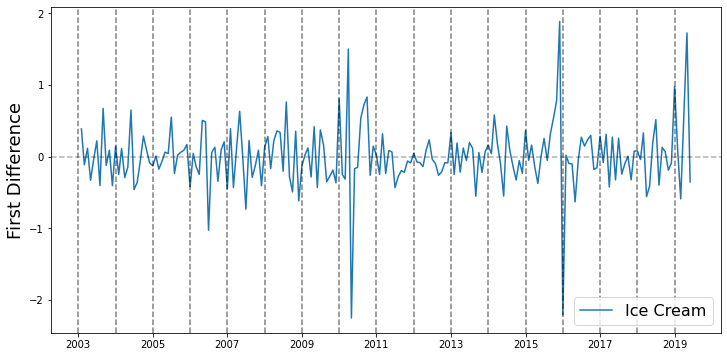

In [29]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'])

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream'], fontsize=16)

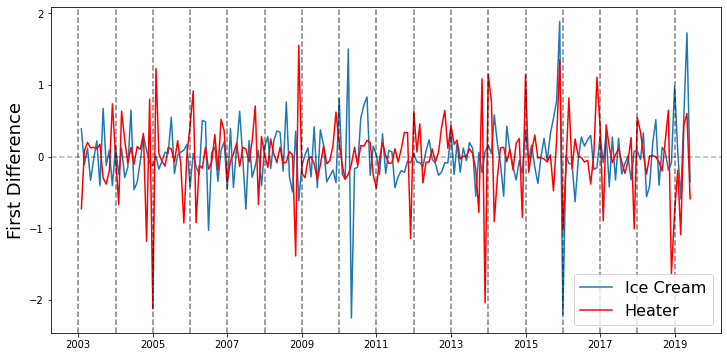

In [30]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'])
heater, = plt.plot(ice_cream_heater_df['heater'], color='red')

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

# PACF - Heater

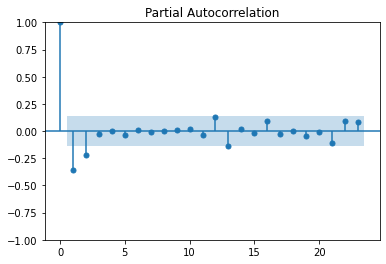

In [31]:
plot_pacf(ice_cream_heater_df['heater'])
plt.show()

## So consider an AR(2)

# Correlation between "heater" and lagged "ice cream"

In [32]:
for lag in range(1, 14):
    heater_series = ice_cream_heater_df['heater'].iloc[lag:]
    lagged_ice_cream_series = ice_cream_heater_df['ice cream'].iloc[:-lag]
    print('Lag: %s'%lag)
    print(pearsonr(heater_series, lagged_ice_cream_series))
    print('------')

Lag: 1
PearsonRResult(statistic=-0.031544507425915636, pvalue=0.6607284991749967)
------
Lag: 2
PearsonRResult(statistic=-0.09872703210944635, pvalue=0.1697084190508982)
------
Lag: 3
PearsonRResult(statistic=-0.0017838553789235895, pvalue=0.9803056762962026)
------
Lag: 4
PearsonRResult(statistic=0.060239718598255415, pvalue=0.4052979832528944)
------
Lag: 5
PearsonRResult(statistic=-0.054034864480150276, pvalue=0.45664426275062703)
------
Lag: 6
PearsonRResult(statistic=0.06461183026553836, pvalue=0.37453000434454764)
------
Lag: 7
PearsonRResult(statistic=-0.04949334618415865, pvalue=0.49768766857621993)
------
Lag: 8
PearsonRResult(statistic=0.07890837135977341, pvalue=0.2804548970433407)
------
Lag: 9
PearsonRResult(statistic=-0.0532350169960043, pvalue=0.4681034202228288)
------
Lag: 10
PearsonRResult(statistic=0.029536989060791177, pvalue=0.6882054906332707)
------
Lag: 11
PearsonRResult(statistic=-0.059795363515225686, pvalue=0.41752174204858805)
------
Lag: 12
PearsonRResult(s

# Fit a VAR Model

In [33]:
ice_cream_heater_df = ice_cream_heater_df[['ice cream', 'heater']]

In [34]:
model = VAR(ice_cream_heater_df)

In [35]:

model_fit = model.fit(maxlags=13)

In [36]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 07, Apr, 2023
Time:                     08:56:51
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.92349
Nobs:                     184.000    HQIC:                  -2.48459
Log likelihood:          -204.405    FPE:                  0.0571123
AIC:                     -2.86700    Det(Omega_mle):       0.0434311
--------------------------------------------------------------------
Results for equation ice cream
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.016054         0.034105           -0.471           0.638
L1.ice cream         -0.287811         0.079633           -3.614           0.000
L1.heater            -0.121251         0.073673         

# So our final model is:

$$
\hat{h}_t = - 0.41h_{t-1} - 0.19h_{t-2} + 0.2i_{t-13}
$$